In [76]:
import torch

print(torch.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())
print(torch.cuda.get_device_capability())

2.0.1+cu118
True
NVIDIA GeForce GTX 1650
(7, 5)


In [77]:
"""
RuntimeError: Only Tensors of floating point and complex dtype can require gradients
"""
# a = torch.tensor(1, requires_grad=True)

# print(a)

'\nRuntimeError: Only Tensors of floating point and complex dtype can require gradients\n'

#### Pytorch计算图

Pytorch与Tensorflow不同，其使用动态计算图(dynamic computational graphs), 更易于调试。更准确来讲，其使用的是`有向无环图(directed acyclic graph, DAG)`.

如下是一个计算示例：

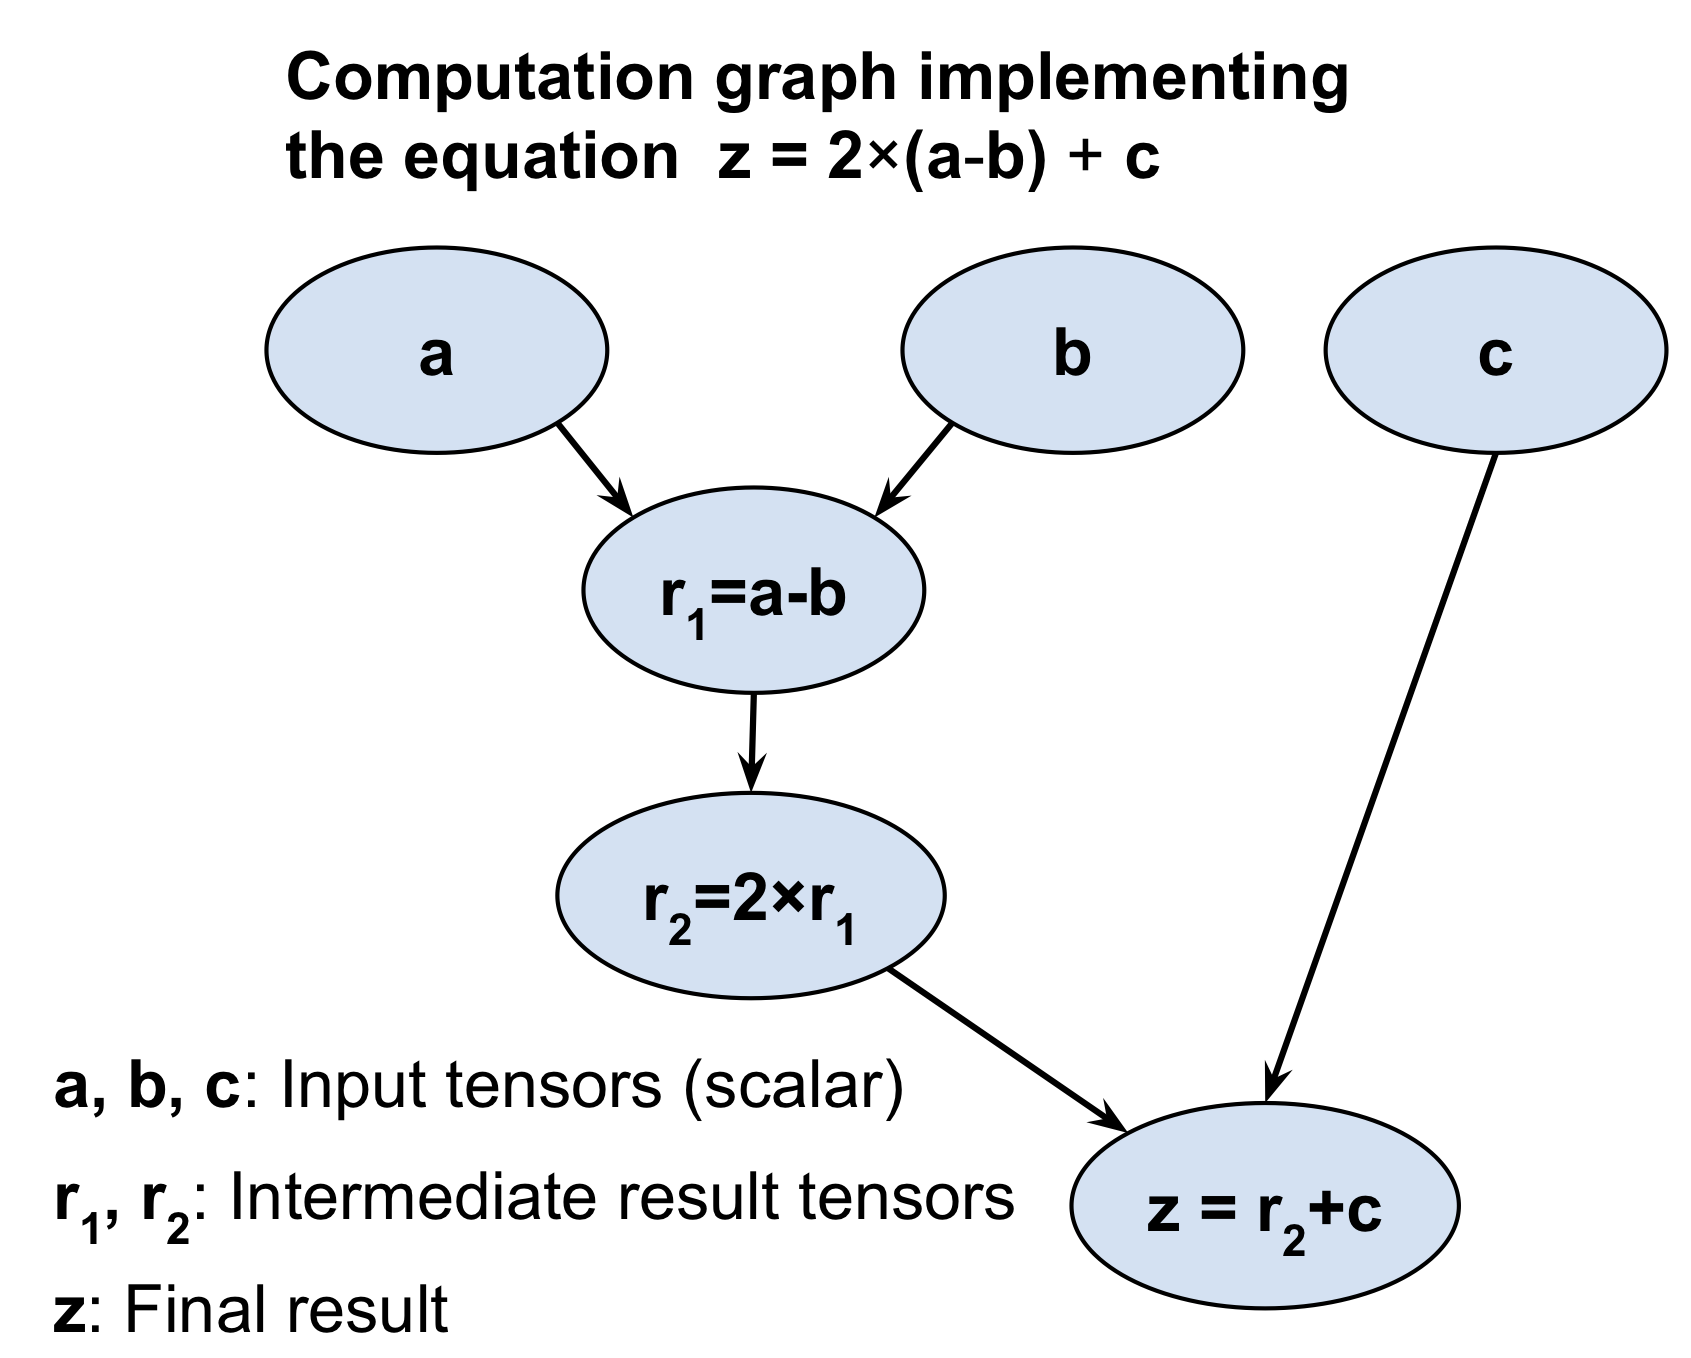

In [78]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter13/figures/13_01.png', 
      width=450)

##### 利用Python创建一个计算图

In [79]:
import torch

def compute_z(a, b, c):
    r1 = torch.sub(a, b)
    r2 = torch.mul(r1, 2)
    z = torch.add(r2, c)
    return z

In [80]:
print('Scalar Inputs:', compute_z(torch.tensor(1), torch.tensor(2), 
                                  torch.tensor(3)))

Scalar Inputs: tensor(1)


In [81]:
print('Rank 1 Inputs:', compute_z(torch.tensor([1]), torch.tensor([2]), 
                                  torch.tensor([3])))

Rank 1 Inputs: tensor([1])


In [82]:
print('Rank 2 Inputs:', compute_z(torch.tensor([[1]]), torch.tensor([[2]]), 
                                  torch.tensor([[3]])))

Rank 2 Inputs: tensor([[1]])


#### 用于存储和更新模型参数的Pytorch张量对象

In [83]:
a = torch.tensor(3.14, requires_grad=True)
print(a)

tensor(3.1400, requires_grad=True)


In [84]:
b = torch.tensor([1.0, 2.0, 3.0], requires_grad=True)
print(b)

tensor([1., 2., 3.], requires_grad=True)


需要注意的是，requires_grad默认设置为False. 通过`requires_grad_()`可以设置为True.

method_()是Pytorch中的一种原地操作方法，无需复制输入.

示例如下：

In [85]:
# 原地操作，设置requires_grad=True.
w = torch.tensor([1.0, 2.0, 3.0])
print(w.requires_grad)

w.requires_grad_()
print(w)

False
tensor([1., 2., 3.], requires_grad=True)


#### 关于参数的随机初始化.

In [86]:
# 这里使用Glorot initialization.
import torch.nn as nn

torch.manual_seed(1)
w = torch.empty(2, 3)
nn.init.xavier_normal_(w)
print(w)

tensor([[ 0.4183,  0.1688,  0.0390],
        [ 0.3930, -0.2858, -0.1051]])


Glorot initialization是由Xavier Glorot和Yoshua Bengio等人提出的. `这种方法背后的思想是：粗略地平衡不同层之间的梯度方差， 否则某些层可能会在训练期间受到过多关注`.

根据这[两个人的论文](https://proceedings.mlr.press/v9/glorot10a)，如果我们需要以均匀分布初始化权重，我们应该选择如下分布：
$$W\sim Uniform\left(-\frac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}},\frac{\sqrt{6}}{\sqrt{n_{in}+n_{out}}}\right)$$

其中，$n_{in}$是与权重相乘的输入神经元的数量，$n_{out}$是输入到下一层的输出神经元数量.为了从高斯分布初始化权重，建议采用的高斯分布标准差为：
$$\sigma=\frac{\sqrt{2}}{\sqrt{n_{in}+n_{out}}}$$

In [87]:
# 一个实现示例.
class MyMoudle(nn.Module):
    def __init__(self):
        super().__init__()
        self.w1 = torch.empty(2, 3, requires_grad=True)
        nn.init.xavier_normal_(self.w1)
        self.w2 = torch.empty(1, 2, requires_grad=True)
        nn.init.xavier_normal_(self.w2)

#### 通过自动微分计算梯度

优化神经网络需要计算损失函数相对于权重的梯度，这是优化算法(例如SGD)所必须的。此外，梯度还有其他应用：

`例如，题刻可以诊断NN模型为什么对测试示例做出特定预测`.

In [88]:
# 一个Python计算示例.
w = torch.tensor(1.0, requires_grad=True)
b = torch.tensor(0.5, requires_grad=True)

x = torch.tensor([1.4])
y = torch.tensor([2.1])
z = torch.add(torch.mul(w, x), b)

loss = (y-z).pow(2).sum()
loss.backward()

print('dl/dw: ', w.grad)
print('dl/db: ', b.grad)

dl/dw:  tensor(-0.5600)
dl/db:  tensor(-0.4000)


In [89]:
# 对上述计算过程的一个验证.
print("manual calculate:", (2 * x *((w * x + b) - y)))

manual calculate: tensor([-0.5600], grad_fn=<MulBackward0>)


#### 通过torch.nn模块简化常见架构的实现

##### 基于nn.Sequential来实现模型

In [90]:
# 使用nn.Sequential, 则模型内部存储的层以级联方式连接, 一个示例如下：
model = nn.Sequential(nn.Linear(4, 16), 
                      nn.ReLU(),
                      nn.Linear(16, 32), 
                      nn.ReLU())

model

Sequential(
  (0): Linear(in_features=4, out_features=16, bias=True)
  (1): ReLU()
  (2): Linear(in_features=16, out_features=32, bias=True)
  (3): ReLU()
)

In [91]:
# 对上述定义的两个线性层进行配置.
nn.init.xavier_normal_(model[0].weight)
l1_weight = 0.01
l1_penalty = l1_weight * model[2].weight.abs().sum()

在上述代码中，对第一个Linear层的权重使用了Xavier初始化, 对第二个Linear层使用了L1正则化，且权重系数为0.01.

进一步为模型指定优化器和损失函数.

##### 选择一个损失函数

In [92]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

#### 解决XOR分类问题

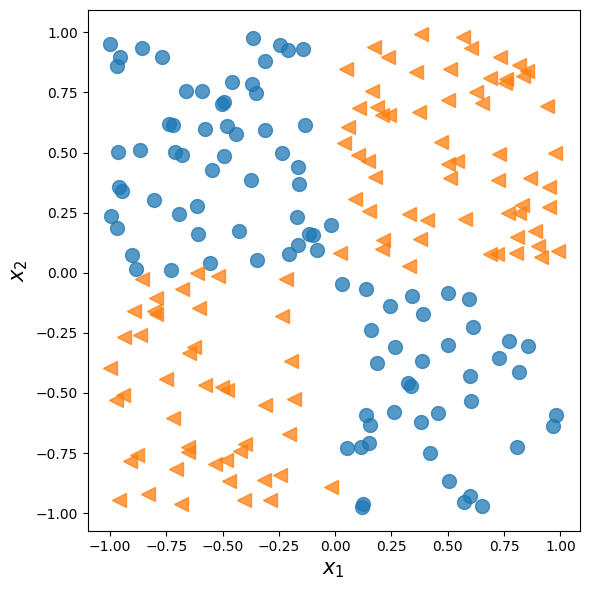

In [93]:
# 生成一个示例数据.
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


np.random.seed(1)
torch.manual_seed(1)
x = np.random.uniform(low=-1, high=1, size=(200, 2))
y = np.ones(len(x))
y[x[:, 0] * x[:, 1]<0] = 0

n_train = 100
x_train = torch.tensor(x[:n_train, :], dtype=torch.float32)
y_train = torch.tensor(y[:n_train], dtype=torch.float32)
x_valid = torch.tensor(x[n_train:, :], dtype=torch.float32)
y_valid = torch.tensor(y[n_train:], dtype=torch.float32)

fig = plt.figure(figsize=(6, 6))
plt.plot(x[y==0, 0], 
         x[y==0, 1], 'o', alpha=0.75, markersize=10)
plt.plot(x[y==1, 0], 
         x[y==1, 1], '<', alpha=0.75, markersize=10)
plt.xlabel(r'$x_1$', size=15)
plt.ylabel(r'$x_2$', size=15)
plt.tight_layout()
plt.savefig('../Python-MachineLearning/Attached_images/Chapter13/figures/13_02.png', 
            dpi=600)
plt.show()

模型容量可以被认为是衡量模型逼近复杂函数的难易程度的指标. 虽然拥有更多参数意味着网络可以拟合更加复杂的函数，但更大的模型通常更加难以训练(并且容易过拟合).`在实践中，以简单模型作为一个基线是一个推荐的做法`，如下是一个简单的逻辑回归：

##### model1: 简单的逻辑回归

In [94]:
# 创建一个DataLoader.
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 2
torch.manual_seed(1)

# 使用DataLoader加载数据，batchsize为2.
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [95]:
# 定义一个简单的模型.
model = nn.Sequential(nn.Linear(2, 1), 
                      nn.Sigmoid())

model

Sequential(
  (0): Linear(in_features=2, out_features=1, bias=True)
  (1): Sigmoid()
)

In [96]:
# 定义损失函数与优化器.
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [97]:
# 模型训练， 设置epoch=200.
torch.manual_seed(1)
num_epochs = 200
def train(model, num_epochs, train_dl, x_valid, y_valid):
    # 存储训练中的各项指标.
    loss_hist_train = [0] * num_epochs
    acc_hist_train = [0] * num_epochs

    loss_hist_valid = [0] * num_epochs
    acc_hist_valid = [0] * num_epochs

    for epoch in range(num_epochs):
        for x_batch, y_batch in train_dl:
            # 模型拟合.
            pred = model(x_batch)[:, 0]
            loss = loss_fn(pred, y_batch)
            # 误差反向传播.
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loss_hist_train[epoch] += loss.item()
            is_correct = ((pred>=0.5).float() == y_batch).float()
            acc_hist_train[epoch] += is_correct.mean()
        loss_hist_train[epoch] /= n_train/batch_size
        acc_hist_train[epoch] /= n_train/batch_size

        pred = model(x_valid)[:, 0]
        loss = loss_fn(pred, y_valid)
        loss_hist_valid[epoch] = loss.item()
        is_correct = ((pred>=0.5).float() == y_valid).float()
        acc_hist_valid[epoch] += is_correct.mean()
    return loss_hist_train, loss_hist_valid, \
            acc_hist_train, acc_hist_valid

history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

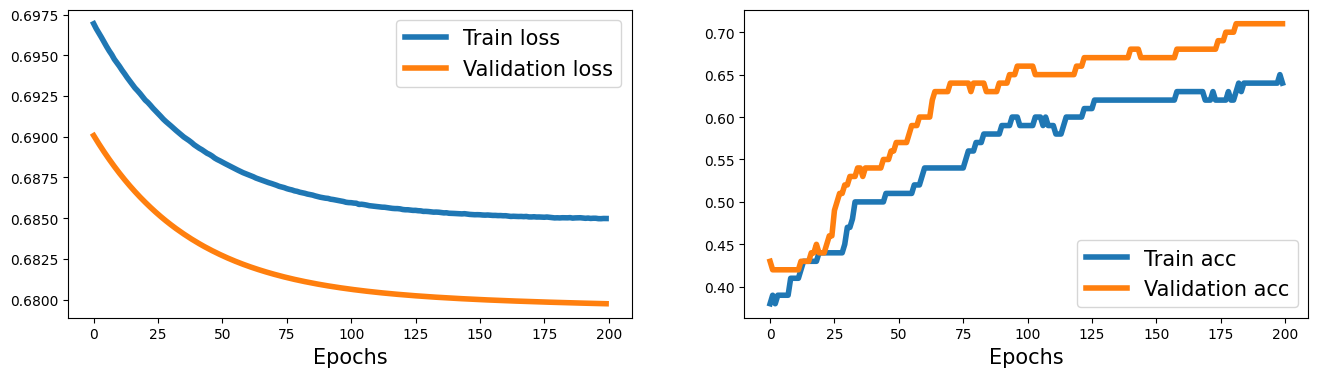

In [98]:
# 绘制学习曲线.
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc', 'Validation acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

##### model2:增加一个全连接层

In [99]:
model = nn.Sequential(nn.Linear(2, 4), 
                      nn.ReLU(), 
                      nn.Linear(4, 4), 
                      nn.ReLU(), 
                      nn.Linear(4, 1), 
                      nn.Sigmoid())
model

Sequential(
  (0): Linear(in_features=2, out_features=4, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
  (5): Sigmoid()
)

In [100]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

In [101]:
# 模型训练.
history = train(model, num_epochs, train_dl, x_valid, y_valid)

Text(0.5, 0, 'Epochs')

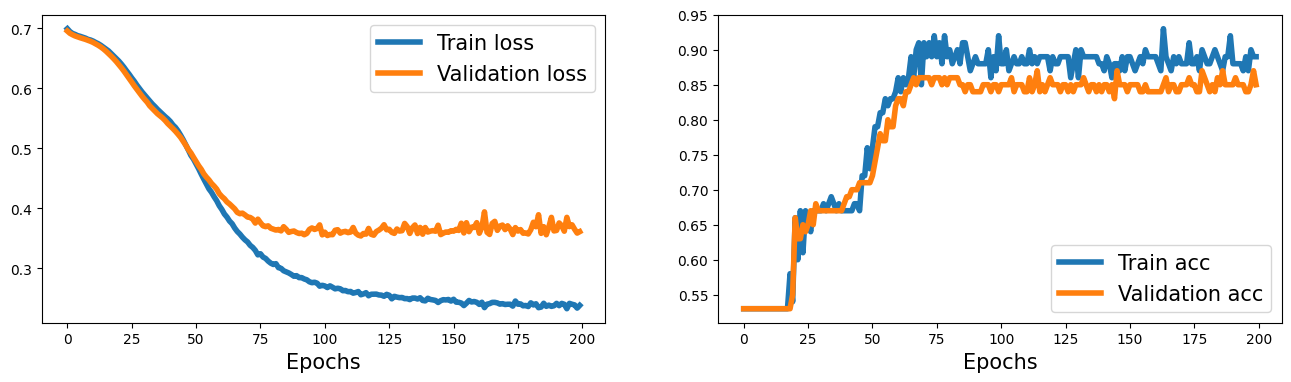

In [102]:
# 绘制学习曲线.
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 2, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc', 'Validation acc'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

#### 使用nn.Module模块创建网络

In [103]:
# 一个示例.
class MyMoudle(nn.Module):
    def __init__(self):
        super().__init__()
        l1 = nn.Linear(2, 4)
        a1 = nn.ReLU()
        l2 = nn.Linear(4, 4)
        a2 = nn.ReLU()
        l3 = nn.Linear(4, 1)
        a3 = nn.Sigmoid()
        l = [l1, a1, l2, a2, l3, a3]
        self.module_list = nn.ModuleList(l)
        """
        模块容器: nn.ModuleList 是一个模块容器，允许将多个子模块存储在一个列表中。这样可以方便地管理和迭代这些模块，尤其是在 forward 方法中。

        参数管理: nn.ModuleList 会确保包含在其中的所有模块的参数都被注册为模型的一部分。这意味着当你调用 model.parameters() 时，它会包括 ModuleList 中所有子模块的参数。

        可迭代性：当你在 forward 方法中使用 for f in self.module_list 迭代时，可以简单地逐层应用每个模块（线性变换和激活函数），而不需要手动处理它们的存储和调用。

        灵活性：你可以动态地创建和修改模块列表，允许你在模型设计中具有更大的灵活性。
        """

    def forward(self, x): 
        for f in self.module_list:
            x = f(x) 
        return x

   # 这个是mlxtend所需要的，新加入.
    def predict(self, x):
    # 将模型设置为评估模式.
        self.eval() 
        with torch.no_grad():  
            x = torch.tensor(x, dtype=torch.float32)
            pred = self.forward(x)[:, 0]
            # 根据输出的值进行二分类（0或1）.
            return (pred > 0.5).float()

    # def predict(self, x):
    #     x = torch.tensor(x, dtype=torch.float32)
    #     pred = self.forward(x)[:, 0]
    #     return (pred>=0.5).float()         

In [104]:
# 模型实例化.
model = MyMoudle()
model

MyMoudle(
  (module_list): ModuleList(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=1, bias=True)
    (5): Sigmoid()
  )
)

In [105]:
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)
history = train(model, num_epochs, train_dl, x_valid, y_valid)

In [106]:
# 使用mlxtend绘制决策边界, 需要将如下代码块添加到MyModule类中.
"""def predict(self, x):
    x = torch.tensor(x, dtype=torch.float32)
    pred = self.forward(x)[:, 0]
    return (pred>=0.5).float()"""

# def predict(self, x):
#         # 将模型设置为评估模式
#         self.eval() 
#         with torch.no_grad():  # 不计算梯度
#             output = self.forward(x)
#             # 根据输出的值进行二分类（0或1）
#             return (output > 0.5).float()  

'def predict(self, x):\n    x = torch.tensor(x, dtype=torch.float32)\n    pred = self.forward(x)[:, 0]\n    return (pred>=0.5).float()'

#### 使用mlxtend绘制决策边界

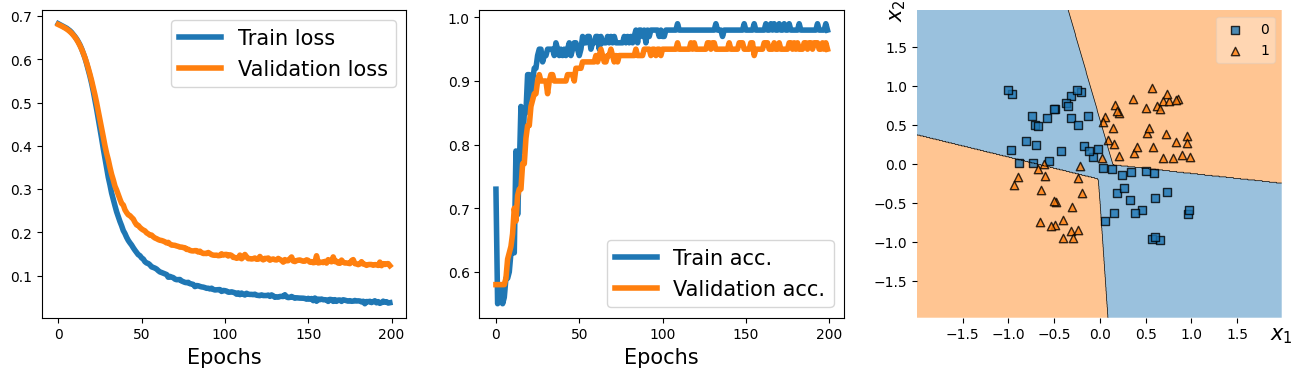

In [107]:
from mlxtend.plotting import plot_decision_regions


fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(history[0], lw=4)
plt.plot(history[1], lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(history[2], lw=4)
plt.plot(history[3], lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)
plt.show()

#### 使用Pytorch编写自定义层

如下定义一个NoisyLinear层， 它用于实现对$w(x+\epsilon)+b$的计算，实现如下：

In [108]:
class NoisyLinear(nn.Module):
    def __init__(self, input_size, output_size, noise_stddev=0.1):
        super().__init__()
        w = torch.Tensor(input_size, output_size)
        self.w = nn.Parameter(w)
        nn.init.xavier_uniform_(self.w)
        b = torch.Tensor(output_size).fill_(0)
        self.b = nn.Parameter(b)
        self.noise_stddev = noise_stddev

    def forward(self, x, training=False):
        if training:
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
            x_new = torch.add(x, noise)
        else:
            x_new = x
        return torch.add(torch.mm(x_new, self.w), self.b)

这段代码定义了一个名为 `NoisyLinear` 的类，它继承自 `nn.Module`，表示一个包含噪声的线性层。

```python
class NoisyLinear(nn.Module):
```
定义一个名为 `NoisyLinear` 的类，它继承自 PyTorch 的 `nn.Module` 类。这意味着它可以被用作一种神经网络层。

```python
    def __init__(self, input_size, output_size, noise_stddev=0.1):
```
初始化方法 `__init__` 接受三个参数：输入大小 `input_size`，输出大小 `output_size`，以及噪声的标准差 `noise_stddev`（默认值为 0.1）。

```python
        super().__init__()
```
调用父类 `nn.Module` 的初始化方法，以确保父类的相关属性和方法被正确初始化。

```python
        w = torch.Tensor(input_size, output_size)
```
创建一个形状为 `(input_size, output_size)` 的张量 `w`，用于存储权重。

```python
        self.w = nn.Parameter(w)
```
将权重 `w` 包装为 `nn.Parameter`，这意味着在训练过程中，PyTorch 会自动将其视为可学习参数。

```python
        nn.init.xavier_uniform_(self.w)
```
使用 Xavier 均匀分布对权重 `self.w` 进行初始化。这是一种常用的初始化方法，有助于保持神经网络中信号的方差。

```python
        b = torch.Tensor(output_size).fill_(0)
```
创建一个形状为 `(output_size,)` 的张量 `b`，并将其填充为 0，用于存储偏置。

```python
        self.b = nn.Parameter(b)
```
将偏置 `b` 包装为 `nn.Parameter`，使其在训练过程中也是可学习的。

```python
        self.noise_stddev = noise_stddev
```
将噪声的标准差 `noise_stddev` 存储为类的一个属性，用于后续的噪声计算。

```python
    def forward(self, x, training=False):
```
定义前向传播方法 `forward`，接受输入 `x` 和一个布尔参数 `training`，指示当前是否在训练模式下。

```python
        if training:
```
检查当前是否处于训练模式。

```python
            noise = torch.normal(0.0, self.noise_stddev, x.shape)
```
如果是训练模式，则创建一个与输入 `x` 形状相同的噪声张量 `noise`，其服从均值为 0、标准差为 `self.noise_stddev` 的正态分布。

```python
            x_new = torch.add(x, noise)
```
将噪声添加到输入 `x` 上，得到新的输入 `x_new`。

```python
        else:
```
如果不是训练模式，则执行以下代码。

```python
            x_new = x
```
在非训练模式下，`x_new` 直接设置为输入 `x`，即没有添加噪声。

```python
        return torch.add(torch.mm(x_new, self.w), self.b)
```
计算输出：首先用 `torch.mm` 进行矩阵乘法（`x_new` 和权重 `self.w`），然后将偏置 `self.b` 添加到结果中。最后返回计算出的输出。

总结来说，这个类实现了一个带噪声的线性变换，在线性层中可以根据训练模式选择性地添加噪声。  

In [109]:
# 1、实例化这个层，并调用三次.
torch.manual_seed(1)

noisy_layer = NoisyLinear(4, 2)
x = torch.zeros((1, 4))
print(noisy_layer(x, training=True))

print(noisy_layer(x, training=True))

print(noisy_layer(x, training=False))

tensor([[ 0.1154, -0.0598]], grad_fn=<AddBackward0>)
tensor([[ 0.0432, -0.0375]], grad_fn=<AddBackward0>)
tensor([[0., 0.]], grad_fn=<AddBackward0>)


In [110]:
# 2、创建一个新的模型，并且调用上述的自定义层.
class MyNoiseModule(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1 = NoisyLinear(2, 4, 0.07)
        self.a1 = nn.ReLU()
        self.l2 = nn.Linear(4, 4)
        self.a2 = nn.ReLU()
        self.l3 = nn.Linear(4, 1)
        self.a3 = nn.Sigmoid()

    def forward(self, x, training=False):
        x = self.l1(x, training)
        x = self.a1(x)
        x = self.l2(x)
        x = self.a2(x)
        x = self.l3(x)
        x = self.a3(x)
        return x
    
    """
        def predict(self, x):
    # 将模型设置为评估模式.
        self.eval() 
        with torch.no_grad():  
            x = torch.tensor(x, dtype=torch.float32)
            pred = self.forward(x)[:, 0]
            # 根据输出的值进行二分类（0或1）.
            return (pred > 0.5).float()
    """
    def predict(self, x):
        self.eval()
        with torch.no_grad():
            x = torch.tensor(x, dtype=torch.float32)
            pred = self.forward(x)[:, 0]
            return (pred>=0.5).float()

In [111]:
# 模型实例化.
torch.manual_seed(1)
model = MyNoiseModule()
model

MyNoiseModule(
  (l1): NoisyLinear()
  (a1): ReLU()
  (l2): Linear(in_features=4, out_features=4, bias=True)
  (a2): ReLU()
  (l3): Linear(in_features=4, out_features=1, bias=True)
  (a3): Sigmoid()
)

In [112]:
# 3.在训练training batch上计算预测结果.
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.015)

torch.manual_seed(1)
loss_hist_train = [0] * num_epochs
acc_hist_train = [0] * num_epochs

loss_hist_valid = [0] * num_epochs
acc_hist_valid = [0] * num_epochs

for epoch in range(num_epochs):
    for x_batch, y_batch in train_dl:
        pred = model(x_batch, True)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_hist_train[epoch] += loss.item()
        is_correct = ((pred>=0.5).float() == y_batch).float()
        acc_hist_train[epoch] += is_correct.mean()
    loss_hist_train[epoch] /= n_train/batch_size
    acc_hist_train[epoch] /= n_train/batch_size

    pred = model(x_valid)[:, 0]
    loss = loss_fn(pred, y_valid)
    loss_hist_valid[epoch] = loss.item()
    is_correct = ((pred>=0.5).float() == y_valid).float()
    acc_hist_valid[epoch] += is_correct.mean()

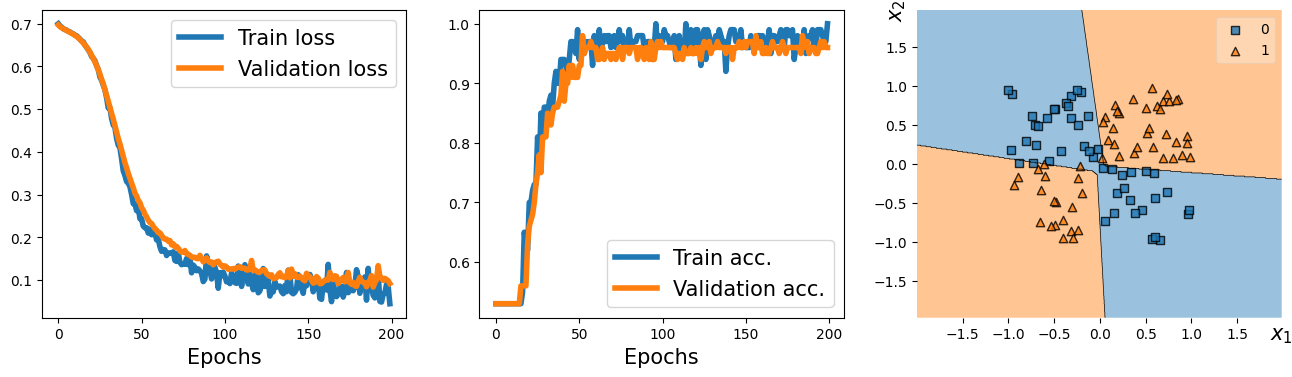

In [113]:
# 绘制决策边界.
from mlxtend.plotting import plot_decision_regions

fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
plt.plot(loss_hist_train, lw=4)
plt.plot(loss_hist_valid, lw=4)
plt.legend(['Train loss', 'Validation loss'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 2)
plt.plot(acc_hist_train, lw=4)
plt.plot(acc_hist_valid, lw=4)
plt.legend(['Train acc.', 'Validation acc.'], fontsize=15)
ax.set_xlabel('Epochs', size=15)

ax = fig.add_subplot(1, 3, 3)
plot_decision_regions(X=x_valid.numpy(), 
                      y=y_valid.numpy().astype(np.int64),
                      clf=model)
ax.set_xlabel(r'$x_1$', size=15)
ax.xaxis.set_label_coords(1, -0.025)
ax.set_ylabel(r'$x_2$', size=15)
ax.yaxis.set_label_coords(-0.025, 1)

plt.show()

#### 项目1：预测汽车燃油效率

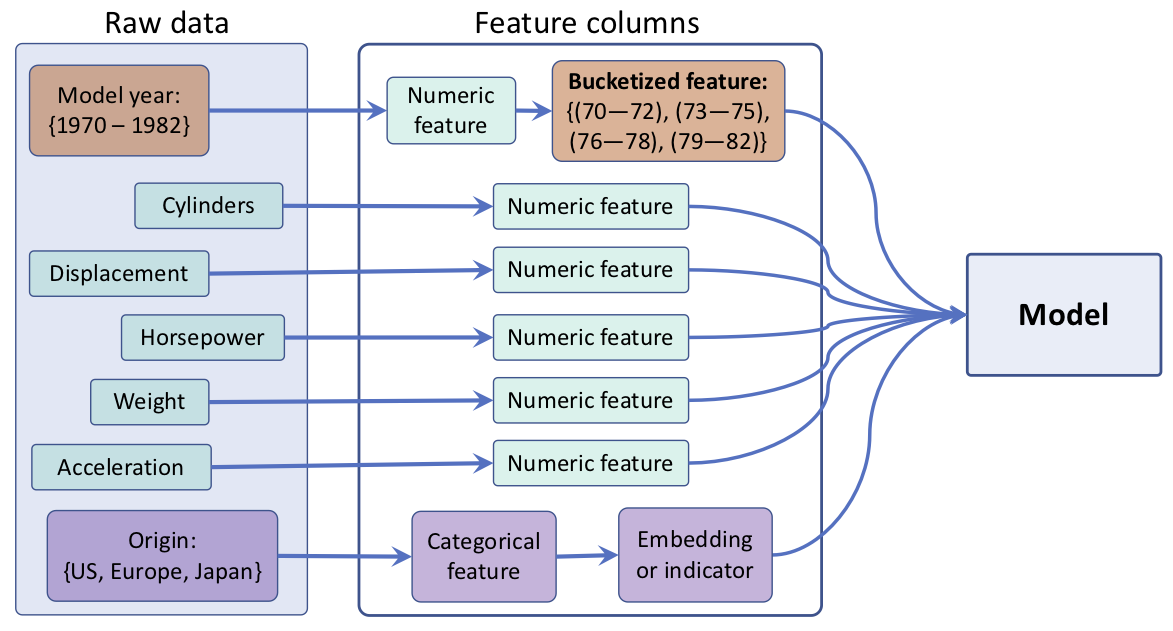

In [114]:
from IPython.display import Image

Image(filename='../Python-MachineLearning/Attached_images/Chapter13/figures/13_07.png', 
      width=450)

In [115]:
# 数据获取.
import pandas as pd
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

df = pd.read_csv(url, names=column_names, 
                 na_values="?", comment='\t', 
                 sep=" ", skipinitialspace=True)

df.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [116]:
df.to_csv('../Python-MachineLearning/Datasets/car_fule_efficient/fule_efficient.csv', index=None)

In [117]:
# 统计并删除缺失值所在行.
print(df.isna().sum())

df = df.dropna()
df = df.reset_index(drop=True)
df.tail()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64


,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
387,27.0,4,140.0,86.0,2790.0,15.6,82,1
388,44.0,4,97.0,52.0,2130.0,24.6,82,2
389,32.0,4,135.0,84.0,2295.0,11.6,82,1
390,28.0,4,120.0,79.0,2625.0,18.6,82,1
391,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [118]:
# 重复值统计.
df.duplicated()

0      False
1      False
2      False
3      False
4      False
       ...  
387    False
388    False
389    False
390    False
391    False
Length: 392, dtype: bool

<Axes: >

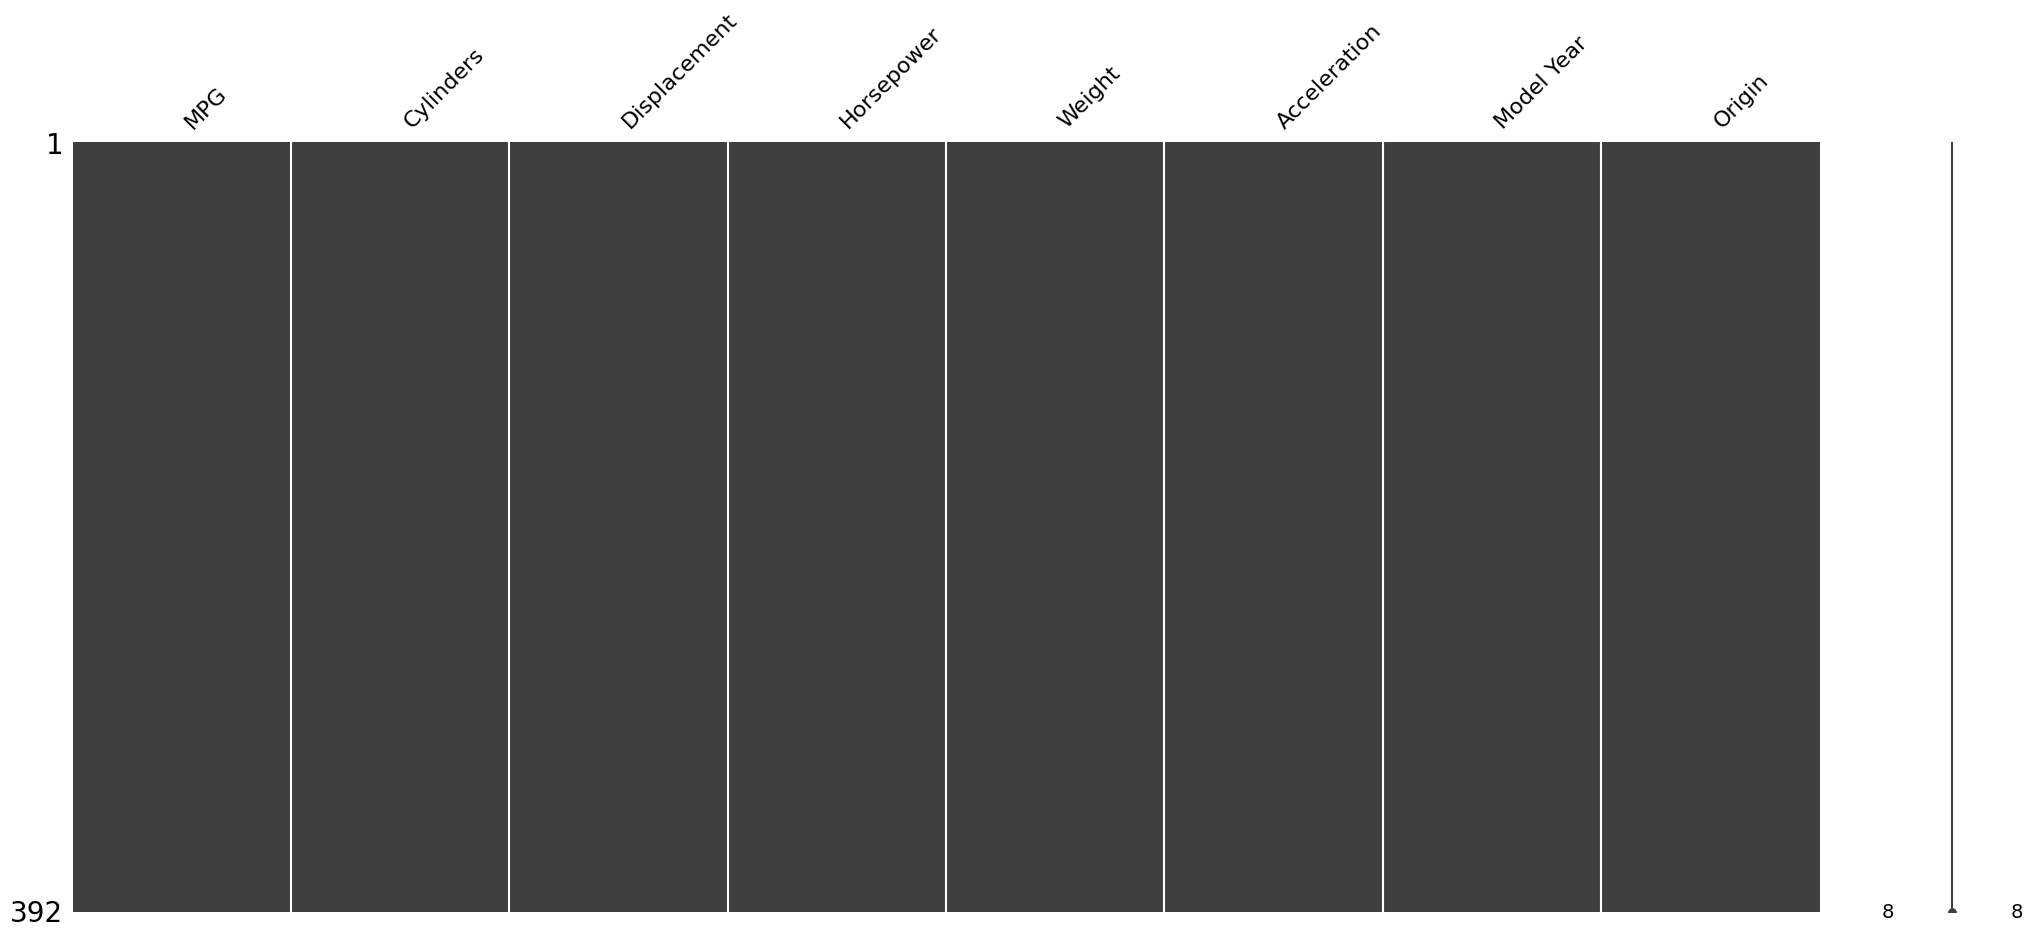

In [119]:
import missingno as msno
%matplotlib inline

msno.matrix(df)

In [120]:
# 训练集和测试集划分.
import sklearn
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, train_size=0.8, random_state=1)
print(df_train.shape)
print(df_test.shape)

(313, 8)
(79, 8)


In [121]:
train_stats = df_train.describe(include='all').transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
MPG,313.0,23.404153,7.666909,9.0,17.5,23.0,29.0,46.6
Cylinders,313.0,5.402556,1.701506,3.0,4.0,4.0,8.0,8.0
Displacement,313.0,189.512780,102.675646,68.0,104.0,140.0,260.0,455.0
Horsepower,313.0,102.929712,37.919046,46.0,75.0,92.0,120.0,230.0
Weight,313.0,2961.198083,848.602146,1613.0,2219.0,2755.0,3574.0,5140.0
Acceleration,313.0,15.704473,2.725399,8.5,14.0,15.5,17.3,24.8
Model Year,313.0,75.929712,3.675305,70.0,73.0,76.0,79.0,82.0
Origin,313.0,1.591054,0.807923,1.0,1.0,1.0,2.0,3.0


In [122]:
# 可以看到，上述数据极值相差较大，所以这里进行标准化处理.
numeric_column_names = ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration']

df_train_norm, df_test_norm = df_train.copy(), df_test.copy()
for col_name in numeric_column_names:
        mean = train_stats.loc[col_name, 'mean']
        std = train_stats.loc[col_name, 'std']
        df_train_norm[col_name] = (df_train_norm[col_name] - mean) / std
        df_test_norm[col_name] = (df_test_norm[col_name] - mean) / std
    
df_train_norm.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
203,28.0,-0.824303,-0.901020,-0.736562,-0.950031,0.255202,76,3
255,19.4,0.351127,0.413800,-0.340982,0.293190,0.548737,78,1
72,13.0,1.526556,1.144256,0.713897,1.339617,-0.625403,72,1
235,30.5,-0.824303,-0.891280,-1.053025,-1.072585,0.475353,77,1
37,14.0,1.526556,1.563051,1.636916,1.470420,-1.359240,71,1


In [123]:
# 分桶处理"Model Year".
# 是连续性特征离散化的一种方式. 处理过程如下：

$$\text{bucket}=\begin{cases}0&\text{if year}<73\\1&\text{if }73\leq\text{year}<76\\2&\text{if }76\leq\text{year}<79\\3&\text{if year}\geq79\end{cases}$$

In [124]:
boundaries = torch.tensor([73, 76, 79])

v = torch.tensor(df_train_norm['Model Year'].values)
"""
when right=True: 如果给定的值恰好等于边界值，它会被视为属于边界右侧的桶。例如，如果边界是 [70, 80]，则 80 将被分配到桶 2，而不是桶 1。

when right=False: 则相反，落在边界值上的数会被视为属于左侧的桶。也就是说，80 将被分配到桶 1。
"""
df_train_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

v = torch.tensor(df_test_norm['Model Year'].values)
df_test_norm['Model Year Bucketed'] = torch.bucketize(v, boundaries, right=True)

numeric_column_names.append('Model Year Bucketed')

In [125]:
# 处理"Origin"这一列，对其进行one-hot.
from torch.nn.functional import one_hot

total_origin = len(set(df_train_norm['Origin']))

origin_encoded = one_hot(torch.from_numpy(df_train_norm['Origin'].values) % total_origin)
x_train_numeric = torch.tensor(df_train_norm[numeric_column_names].values)
x_train = torch.cat([x_train_numeric, origin_encoded], 1).float()

origin_encoded = one_hot(torch.from_numpy(df_test_norm['Origin'].values) % total_origin)
x_test_numeric = torch.tensor(df_test_norm[numeric_column_names].values)
x_test = torch.cat([x_test_numeric, origin_encoded], 1).float()


In [126]:
print(x_train.shape, x_test.shape)

torch.Size([313, 9]) torch.Size([79, 9])


In [127]:
y_train = torch.tensor(df_train_norm['MPG'].values).float()
y_test = torch.tensor(df_test_norm['MPG'].values).float()

In [128]:
# 创建DataLoader.
from torch.utils.data import DataLoader, TensorDataset

train_ds = TensorDataset(x_train, y_train)
batch_size = 8

torch.manual_seed(1)
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [129]:
# 定义模型.
hidden_units = [8, 4]
"""
这一行定义了一个名为 hidden_units 的列表，
表示模型中隐藏层的神经元数量。
第一个隐藏层有 8 个神经元，第二个隐藏层有 4 个神经元。
"""
input_size = x_train.shape[1]

all_layers = []
for hidden_unit in hidden_units:
    layer = nn.Linear(input_size, hidden_unit)
    all_layers.append(layer)
    all_layers.append(nn.ReLU())
    input_size = hidden_unit

all_layers.append(nn.Linear(hidden_units[-1], 1))
model = nn.Sequential(*all_layers)

model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [130]:
# 使用常用的Sequential习惯重写.
# 使用nn.Sequential, 则模型内部存储的层以级联方式连接, 一个示例如下：
model = nn.Sequential(nn.Linear(9, 8), 
                      nn.ReLU(),
                      nn.Linear(8, 4), 
                      nn.ReLU(), 
                      nn.Linear(4, 1))

model

Sequential(
  (0): Linear(in_features=9, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=1, bias=True)
)

In [131]:
# 定义损失函数和优化器.
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

In [133]:
# 模型训练.
torch.manual_seed(1)

num_epochs = 200
log_epochs = 20
for epoch in range(num_epochs):
    loss_hist_train = 0
    for x_batch, y_batch in train_dl:
        pred = model(x_batch)[:, 0]
        loss = loss_fn(pred, y_batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss_hist_train += loss.item()
    if epoch % log_epochs == 0:
        print(f'Epoch {epoch}  Loss {loss_hist_train/len(train_dl):.4f}')

Epoch 0  Loss 18.1396
Epoch 20  Loss 7.5811
Epoch 40  Loss 6.9964
Epoch 60  Loss 6.6743
Epoch 80  Loss 6.2975
Epoch 100  Loss 6.2419
Epoch 120  Loss 5.8646
Epoch 140  Loss 6.1892
Epoch 160  Loss 6.4162
Epoch 180  Loss 6.0346


In [134]:
with torch.no_grad():
    pred = model(x_test.float())[:, 0]
    loss = loss_fn(pred, y_test)
    print(f'Test MSE: {loss.item():.4f}')
    print(f'Test MAE: {nn.L1Loss()(pred, y_test).item():.4f}')

Test MSE: 8.9176
Test MAE: 1.9243
